# Online News Popularity Prediction

**Dataset Source:** [Online News Popularity Dataset](https://www.kaggle.com/datasets/ishantjuyal/online-news-popularity)

**Objective:**  
Predict the number of shares an online news article will receive on social media platforms based on various features extracted from the article and its metadata.

---

## Table of Contents
1. [Introduction](#Introduction)
2. [Problem Statement](#Problem-Statement)
3. [Data Loading and Overview](#Data-Loading-and-Overview)
4. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis-EDA)
5. [Data Preprocessing](#Data-Preprocessing)
6. [Feature Engineering](#Feature-Engineering)
7. [Model Building and Training](#Model-Building-and-Training)
8. [Model Evaluation](#Model-Evaluation)
9. [Results and Discussion](#Results-and-Discussion)
10. [Conclusion](#Conclusion)
11. [References](#References)

---

## Introduction

In the age of digital media, understanding and predicting the popularity of online news articles is crucial for content creators, marketers, and publishers. This notebook explores the Online News Popularity dataset to build models that predict the number of shares an article will receive on social media platforms. By leveraging various features such as textual content metrics, metadata, and sentiment analysis, we aim to identify key factors that influence article popularity.

---

## Problem Statement

This is a **regression** problem where the objective is to predict the continuous variable **'shares'**, representing the number of times an online news article is shared on social media platforms.

---

## Data Loading and Overview




In [1]:
!pip install shap

DEPRECATION: beakerx-base 2.2.0 has a non-standard dependency specifier ipywidgets<8pandas,>=7.5.1. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of beakerx-base or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# For warnings
import warnings
warnings.filterwarnings('ignore')

# For SHAP
import shap

# Setting visual style
sns.set(style="whitegrid")

In [3]:
# Loading the dataset
df = pd.read_csv('OnlineNewsPopularity.csv')

# Displaying the first five rows
df.head()


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [4]:
# Displaying dataset shape
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")


Dataset contains 39644 rows and 61 columns.


In [5]:
# Listing all columns
df.columns.tolist()


['url',
 ' timedelta',
 ' n_tokens_title',
 ' n_tokens_content',
 ' n_unique_tokens',
 ' n_non_stop_words',
 ' n_non_stop_unique_tokens',
 ' num_hrefs',
 ' num_self_hrefs',
 ' num_imgs',
 ' num_videos',
 ' average_token_length',
 ' num_keywords',
 ' data_channel_is_lifestyle',
 ' data_channel_is_entertainment',
 ' data_channel_is_bus',
 ' data_channel_is_socmed',
 ' data_channel_is_tech',
 ' data_channel_is_world',
 ' kw_min_min',
 ' kw_max_min',
 ' kw_avg_min',
 ' kw_min_max',
 ' kw_max_max',
 ' kw_avg_max',
 ' kw_min_avg',
 ' kw_max_avg',
 ' kw_avg_avg',
 ' self_reference_min_shares',
 ' self_reference_max_shares',
 ' self_reference_avg_sharess',
 ' weekday_is_monday',
 ' weekday_is_tuesday',
 ' weekday_is_wednesday',
 ' weekday_is_thursday',
 ' weekday_is_friday',
 ' weekday_is_saturday',
 ' weekday_is_sunday',
 ' is_weekend',
 ' LDA_00',
 ' LDA_01',
 ' LDA_02',
 ' LDA_03',
 ' LDA_04',
 ' global_subjectivity',
 ' global_sentiment_polarity',
 ' global_rate_positive_words',
 ' global_

Removing Leading and Trailing Whitespace

In [6]:
# Removing leading and trailing whitespaces from column names
df.columns = df.columns.str.strip()

# Displaying cleaned column names
print("\nCleaned Column Names:")
print(df.columns.tolist())



Cleaned Column Names:
['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'av

In [7]:
# Dropping non-predictive columns
df_clean = df.drop(['url', 'timedelta'], axis=1)

# Verify the columns after cleaning and dropping
print("\nColumns after cleaning and dropping non-predictive features:")
print(df_clean.columns.tolist())


Columns after cleaning and dropping non-predictive features:
['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_n

---

# Exploratory Data Analysis (EDA)
### 1. Understanding the Target Variable

In [8]:
# Description of target variable
print("Description of 'shares' variable:")
print(df['shares'].describe())


Description of 'shares' variable:
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64


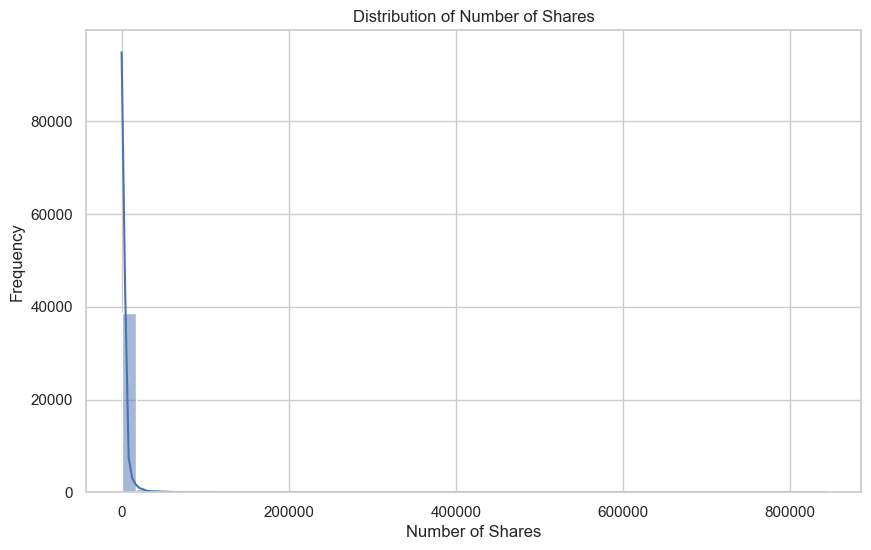

In [9]:
# Distribution of 'shares'
plt.figure(figsize=(10,6))
sns.histplot(df['shares'], bins=50, kde=True)
plt.title('Distribution of Number of Shares')
plt.xlabel('Number of Shares')
plt.ylabel('Frequency')
plt.show()


The distribution of shares is highly skewed, indicating that most articles receive a low number of shares, while a few go viral.

### Log Transformation of Target Variable

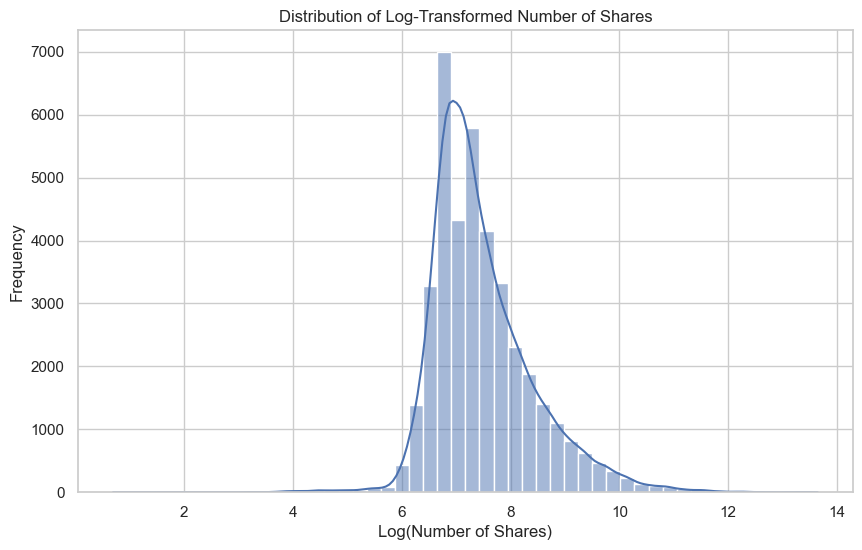

In [11]:
# Applying log transformation to the target variable
df['log_shares'] = np.log1p(df['shares'])

# Plotting the transformed target variable
plt.figure(figsize=(10,6))
sns.histplot(df['log_shares'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Number of Shares')
plt.xlabel('Log(Number of Shares)')
plt.ylabel('Frequency')
plt.show()


The log transformation normalizes the distribution, making it more suitable for regression modeling.

### 2. Checking for Missing Values

In [14]:
# Checking for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])


Missing values in each column:
Series([], dtype: int64)


There are no missing values in the dataset.

### 3. Statistical Summary

In [15]:
# Statistical summary
df.describe()


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,log_shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184,7.475692
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749,0.929674
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,0.693147
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000,6.853299
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000,7.244942
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000,7.937732
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000,13.645079


### 4. Correlation Analysis

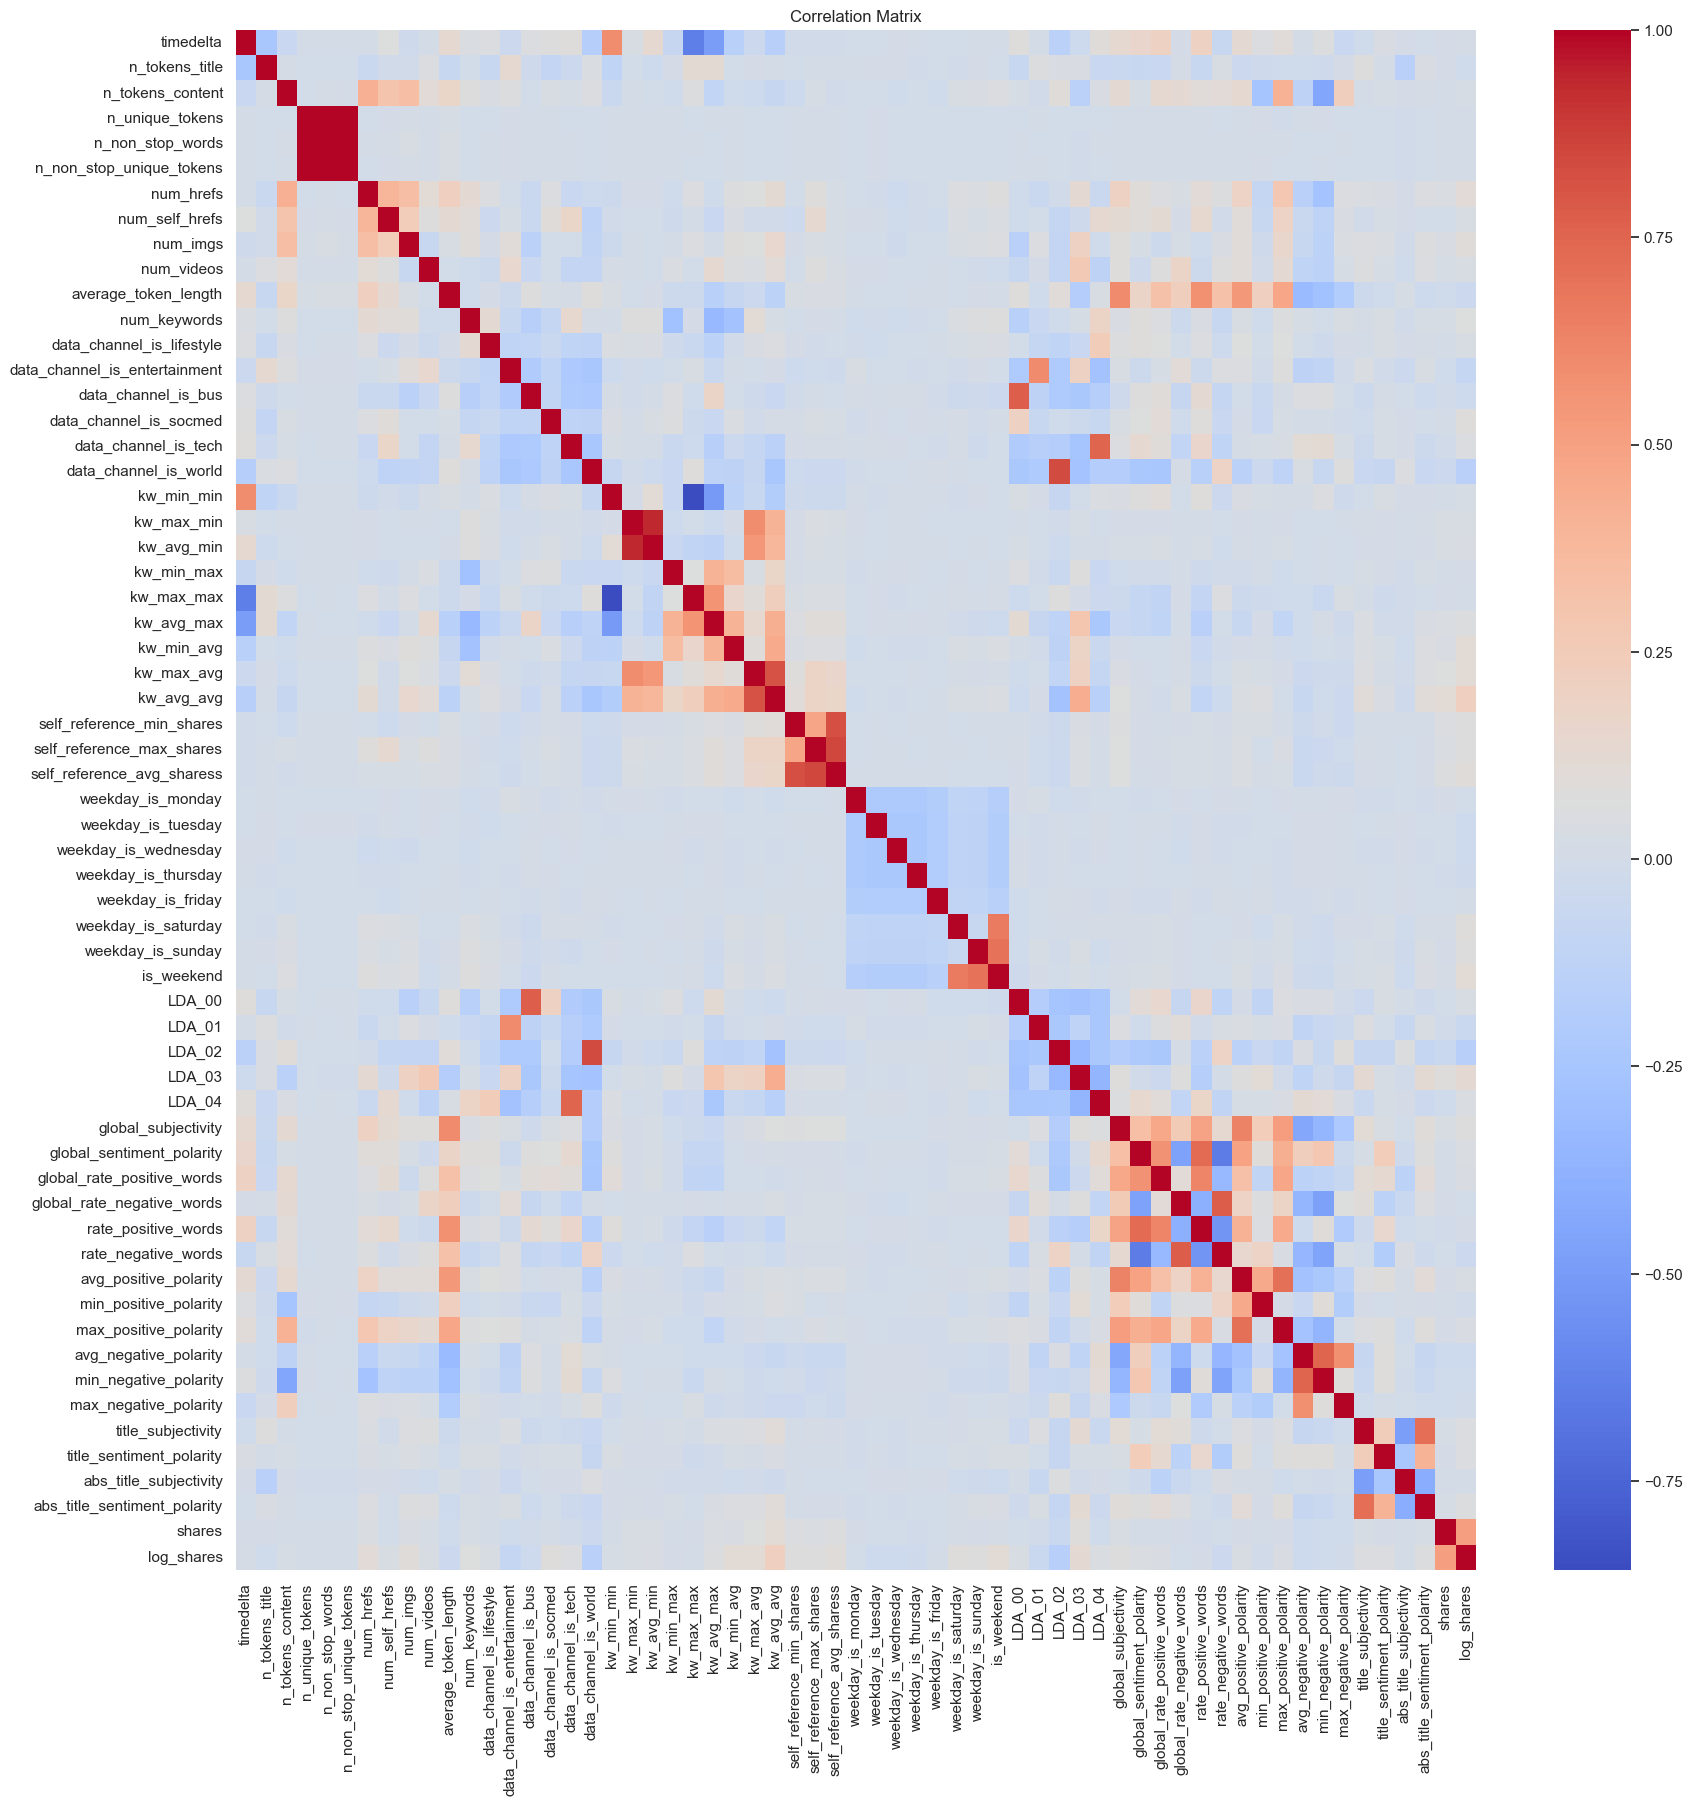

In [16]:
# Correlation matrix
plt.figure(figsize=(20,20))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [17]:
# Correlation with target variable
corr_with_target = corr_matrix['shares'].sort_values(ascending=False)
print("Top 10 features positively correlated with shares:")
print(corr_with_target.tail(-1).tail(10))

print("\nTop 10 features negatively correlated with shares:")
print(corr_with_target.tail(-1).head(10))


Top 10 features positively correlated with shares:
rate_positive_words             -0.013241
data_channel_is_tech            -0.013253
LDA_04                          -0.016622
data_channel_is_entertainment   -0.017006
min_negative_polarity           -0.019297
max_negative_polarity           -0.019300
average_token_length            -0.022007
avg_negative_polarity           -0.032029
data_channel_is_world           -0.049497
LDA_02                          -0.059163
Name: shares, dtype: float64

Top 10 features negatively correlated with shares:
log_shares                    0.510181
kw_avg_avg                    0.110413
LDA_03                        0.083771
kw_max_avg                    0.064306
self_reference_avg_sharess    0.057789
self_reference_min_shares     0.055958
self_reference_max_shares     0.047115
num_hrefs                     0.045404
kw_avg_max                    0.044686
kw_min_avg                    0.039551
Name: shares, dtype: float64


### Feature Distributions

In [18]:
# Selecting top 5 positively and negatively correlated features
top_positive_features = corr_with_target[1:6].index.tolist()  # Top 5 positive
top_negative_features = corr_with_target[-5:].index.tolist()  # Top 5 negative

# Combine both lists
top_features = top_positive_features + top_negative_features

# Plotting distributions
for feature in top_features:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=df_clean[feature], y=df_clean['shares'])
    plt.title(f'Shares vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Shares')
    plt.show()


KeyError: 'log_shares'

<Figure size 800x400 with 0 Axes>

### 5. Splitting Dataset

In [13]:
# Separating features and target
X = df_clean.drop('shares', axis=1)
y = df_clean['shares']


### 6. Separating features and target


In [14]:
# Selecting top 5 correlated features
top_features = corr_with_target.tail(6).index.tolist()
top_features.remove('shares')

# Plotting distributions
for feature in top_features:
    plt.figure(figsize=(8,4))
    sns.scatterplot(x=df[feature], y=df['shares'])
    plt.title(f'Shares vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Shares')
    plt.show()


ValueError: list.remove(x): x not in list